In [21]:
import pyccl as ccl
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.interpolate import interp1d
from wigner import wigner_dl
from importlib import reload
import inspect
import random

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

In [27]:
concentrations = [getattr(ccl.halos.concentration, o) for o in dir(ccl.halos.concentration) if inspect.isclass(getattr(ccl.halos.concentration, o))]

# Randomly select a function
selected_function = random.choice(concentrations)

# Execute the selected function
# WARNING: This is for demonstration; in real applications, you must handle arguments and exceptions
try:
    result = selected_function()
    print(result)
except:
    pass

<pyccl.halos.concentration.constant.ConcentrationConstant>
	mass_def = MassDef(Delta=200, rho_type=critical)


In [93]:
# define cosmology
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, 
                      h=0.67, sigma8=0.83, n_s=0.96)

# set k array
k_arr = np.geomspace(1E-3, 1e3, 128)

# set scale factor array
a_arr = np.linspace(0.1, 1, 32)

In [103]:
class Cos2CorrCS(object):
    def __init__(self,
                 cosmo,
                 z1, 
                 z2, 
                 theta, 
                 a1h=0.001,
                 b1h=-2,
                 a2h=1
                 ):
        # these are the parameters we want our model to
        #  emulate based on
        self.cosmo = cosmo
        self.z1 = z1
        self.z2 = z2
        self.theta = theta
        self.a1h = a1h
        self.a2h = a2h
        self.b1h = b1h

        # Set up halo model
        # Here we use a mass definition with Delta = 200 times the matter density,
        self.hm_def = '200m'
        # the Duffy 2008 concentration-mass relation,
        self.cM = ccl.halos.ConcentrationDuffy08(mass_def=self.hm_def)
        # the Tinker 2010 halo mass function,
        self.nM = ccl.halos.MassFuncTinker10(mass_def=self.hm_def)
        # the Tinker 2010 halo bias,
        self.bM = ccl.halos.HaloBiasTinker10(mass_def=self.hm_def)
        # and the halo model calculator object.
        self.hmc = ccl.halos.HMCalculator(mass_function=self.nM, 
                                          halo_bias=self.bM, 
                                          mass_def=self.hm_def
                                          )

        # Create z dists (can be updated to use a different distribution))
        z1_0 = 0.1
        self.pz1 = 1./(2.*z1_0) * (z1 / z1_0)**2. * np.exp(-z1/z1_0)

        z2_0 = 0.1
        self.pz2 = 1./(2.*z2_0) * (z2 / z2_0)**2. * np.exp(-z2/z2_0)

        return

    def update_hmc(self, hmc):
        '''
        Update the halo model calculator, this is left here to make it harder
        to accidentally change the halo model parameters, as the initial model
        will be trained on the parameters set in __init__.
        '''
        self.hmc = hmc
        return
    
    def update_dndz(self, z1_func, z2_func):
        '''
        Update the parameterisation of the redshift dfitsributions.
        '''
        self.pz1 = z1_func(self.z1)
        self.pz2 = z2_func(self.z2)
        return

    def cos_2_pk(self, k_arr=None, a_arr=None):

        if not k_arr:
            k_arr = np.geomspace(1e-3, 2e3, 1000)
        if not a_arr:
            a_arr = np.linspace(0.1, 1, 16)

        lk_arr = np.log(k_arr)

        sat_gamma_HOD = ccl.halos.SatelliteShearHOD(mass_def=self.hm_def, concentration=self.cM,
                                                    a1h=self.a1h, b=self.b1h
                                                    )
        
        NFW = ccl.halos.profiles.HaloProfileNFW(mass_def=self.hm_def, concentration=self.cM)

        # Compute the II Power spectra
        pk_II_1h_ss = ccl.halos.halomod_Pk2D(self.cosmo, self.hmc, sat_gamma_HOD, 
                                             get_2h = False, a_arr=a_arr, lk_arr=lk_arr
                                             )

        # Compute here the 2-halo c-s term:
        C1rhocrit = 0.0134
        C = self.a2h * C1rhocrit * self.cosmo['Omega_m'] / self.cosmo.growth_factor(a_arr)
        C_pk_lin = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=lk_arr,
                                pk_arr=(C.reshape(-1,1)
                                        *self.cosmo.linear_matter_power(np.e**lk_arr, a_arr)
                                        ),
                                is_logp=False
                                )
        
        pk_b_gamma = -1 * ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=lk_arr,
                                        pk_arr=ccl.halos.halomod_bias_1pt(self.cosmo, self.hmc, 
                                                                          np.e**lk_arr, 
                                                                          a_arr, sat_gamma_HOD
                                                                          ), 
                                        is_logp=False
                                        )

        pk_GI_1h_s = ccl.halos.halomod_Pk2D(self.cosmo, self.hmc, NFW, 
                                            prof2 = sat_gamma_HOD, get_2h = False, 
                                            a_arr=a_arr, lk_arr=lk_arr
                                            )
        
        C1rhocrit = 0.0134
        C = self.a2h * C1rhocrit * self.cosmo['Omega_m'] / self.cosmo.growth_factor(a_arr)

        k1h = 4*self.cosmo['h'] #1/Mpc
        k2h = 6*self.cosmo['h'] #1/Mpc

        pk_II_NLA_windowed = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=lk_arr,
                                        pk_arr=(C.reshape(-1,1)**2
                                                *cosmo.nonlin_matter_power(np.e**lk_arr, a_arr)
                                                *np.exp(-(k_arr/k2h)**2).reshape(1,-1)
                                                ),
                                        is_logp=False
                                        )
        
        pk_GI_NLA_windowed = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=lk_arr,
                                        pk_arr=(-C.reshape(-1,1)
                                                *cosmo.nonlin_matter_power(np.e**lk_arr, a_arr)
                                                *np.exp(-(k_arr/k2h)**2).reshape(1,-1)
                                                ),
                                        is_logp=False
                                        )

        pk_II_1h_ss_windowed = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=lk_arr,
                                            pk_arr=(pk_II_1h_ss(k_arr, a_arr)
                                                    *(1-np.exp(-(k_arr/k1h)**2)).reshape(1,-1)
                                                    ),
                                            is_logp=False
                                            )
        
        pk_GI_1h_s_windowed = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=lk_arr,
                                            pk_arr=(pk_GI_1h_s(k_arr, a_arr)
                                                    *(1-np.exp(-(k_arr/k1h)**2)).reshape(1,-1)
                                                    ),
                                            is_logp=False
                                            )
        
        pk_II_windowed = pk_II_NLA_windowed+pk_II_1h_ss_windowed
        pk_GI_windowed = pk_GI_NLA_windowed+pk_GI_1h_s_windowed

        return pk_II_windowed, pk_GI_windowed

    def pk_2_corr(self, pk_II_windowed, pk_GI_windowed, pm=1, sampling=4e6):

        b_IA = np.ones(len(self.z1)) # Dummy arguement, needs to be passed but not used.
        ia_tracer_z1 = ccl.WeakLensingTracer(self.cosmo,dndz = (self.z1, self.pz1), 
                                             has_shear=False, ia_bias = (self.z1, b_IA), 
                                             use_A_ia=False
                                             )
        
        ia_tracer_z2 = ccl.WeakLensingTracer(self.cosmo,dndz = (self.z2, self.pz2), 
                                             has_shear=False, ia_bias = (self.z2, b_IA), 
                                             use_A_ia=False
                                             )
        
        wl_tracer_z1 = ccl.WeakLensingTracer(self.cosmo,dndz = (self.z1, self.pz1), has_shear=True)
        wl_tracer_z2 = ccl.WeakLensingTracer(self.cosmo,dndz = (self.z2, self.pz2), has_shear=True)
        
        l_arr = np.unique(np.geomspace(180/(self.theta[-1]/60.) - 10, 
                                       180/(self.theta[0]/60.))).astype(int)
        
        if all(self.z1 != self.z2):
            print('Computing both G1I2 and G2I1...')
            xip_wig_G1I2 = self.wigD_correlation(self.cosmo, l_arr, wl_tracer_z1, 
                                                ia_tracer_z2, 'GG', self.theta/60,
                                                p_of_k_a=pk_GI_windowed, sampling=sampling
                                                )
            xip_wig_G2I1 = self.wigD_correlation(self.cosmo, l_arr, wl_tracer_z2, 
                                                ia_tracer_z1, 'GG', self.theta/60,
                                                p_of_k_a=pk_GI_windowed, sampling=sampling
                                                )
            xip_wig_GI = xip_wig_G1I2 + xip_wig_G2I1
        else:
            xip_wig_GI = self.wigD_correlation(self.cosmo, l_arr, wl_tracer_z1, 
                                                ia_tracer_z2, 'GG', self.theta/60,
                                                p_of_k_a=pk_GI_windowed, sampling=sampling
                                                )
            
        xip_wig_II = self.wigD_correlation(self.cosmo, l_arr, ia_tracer_z1, 
                                           ia_tracer_z2, 'GG', self.theta/60,
                                            p_of_k_a=pk_II_windowed, sampling=sampling
                                            )
        
        cl_GG = ccl.angular_cl(self.cosmo, wl_tracer_z1, wl_tracer_z2, l_arr)
        xip_GG = ccl.correlation(self.cosmo, ell=l_arr, C_ell=cl_GG, theta=self.theta/60, type='GG+')

        xip_tot = xip_GG+xip_wig_II+xip_wig_GI

        return xip_tot
    
    def wigD_correlation(self,
                        cosmo, 
                        l_arr,
                        tracer1, 
                        tracer2,
                        corr, 
                        theta,
                        p_of_k_a=None,
                        pm=1,
                        sampling=1e5
                        ):

        # set spin values based on correlation type provided
        if corr == 'NG':
            sa = 0
            sb = 2
        elif corr == 'GG':
            sa = 2
            sb = 2
        elif corr == 'NN':
            sa = 0
            sb = 0
        else:
            raise ValueError('Not a valid correlation type')
        # define a larger ell array for wigner matrix
        lmin = l_arr.min()
        lmax = int(lmin + sampling)
        ell_arr_sample = np.unique(np.geomspace(lmin, lmax, 1024).astype(int))
        # recompute angular cl
        Cl_sample = ccl.angular_cl(cosmo, tracer1, tracer2, ell_arr_sample, p_of_k_a=p_of_k_a)
        # interpolate to get high density array
        ell_arr  = np.arange(lmin, lmax)
        Cl_intp = interp1d(ell_arr_sample, Cl_sample)

        # loop over theta values and calculate xi at each
        xi = np.zeros_like(theta)
        for th in range(len(theta)):
            # get wigner-d matrix for given theta
            d_ell = wigner_dl(lmin, lmax, sa, sb, np.radians(theta[th]))
            # compute xi value for given theta by summing over ell values
            xi_temp = 0
            prefactor = (2*ell_arr + 1)/(4*np.pi)
            C_ab_l = pm**(sb) * Cl_intp(ell_arr)
            xi_temp += np.sum(prefactor * C_ab_l * d_ell[:-1])
            # record result to array
            xi[th] = xi_temp

        return xi
        

### Test Class

In [115]:
z1 = np.linspace(0., 3., 256)
z2 = z1
theta = np.geomspace(1, 250, 40)

In [116]:
pk_II_windowed, pk_GI_windowed = Cos2CorrCS(cosmo, z1, z2, theta).cos_2_pk()

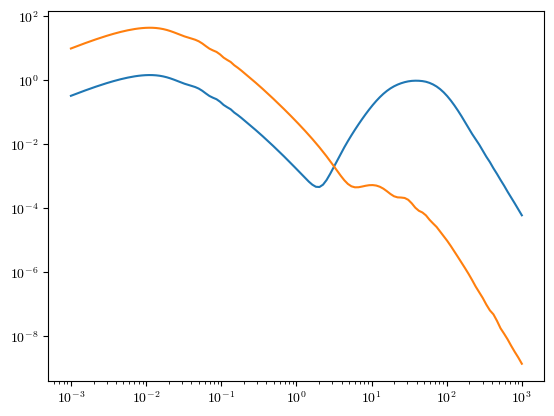

In [112]:
plt.figure()
plt.loglog(k_arr, pk_II_windowed.__call__(k_arr, a_arr[0]))
plt.loglog(k_arr, -pk_GI_windowed.__call__(k_arr, a_arr[0]))
#plt.ylim(1e-11, 1e5)

In [113]:
xi_tot_windowed = Cos2CorrCS(cosmo, z1, z2, theta).pk_2_corr(pk_II_windowed, pk_GI_windowed, sampling=4e6)

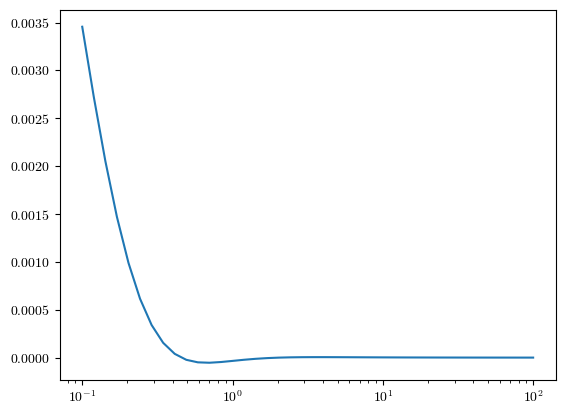

In [114]:
plt.plot(theta, xi_tot_windowed)
plt.xscale('log')

### Create a Latin Hypercube to evenly sample the 17D parameter space
- We can then run calculations for all the points in the hypercube
- This will create an evenly sample training set

In [176]:
from scipy.stats.qmc import LatinHypercube

param_list = ['Omega_b', 'Omega_c', 'h', 'sigma8', 'n_s', 
              'a1h', 'b1h', 'a2h', 
              'z1_0', 'z2_0', 'z1_min', 'z1_max', 'z2_min', 'z2_max']

param_ranges = [[0.046,0.053],[0.2,0.5],[0.67,0.76],[0.78,0.85],[0.8,1.1],
                [1e-4,1e-1], [-3,-0.1], [0.1,1],
                [0.1,0.3],[0.1,0.3],[0,3],[0.2,3.2],[0,3],[0.2,3.2]]

print(len(param_list))
D = 14

n_samples = 1000

lh = LatinHypercube(D)

lh_samples = lh.random(n_samples)

for dim in range(D):
    lh_samples[:,dim] = lh_samples[:,dim]*(param_ranges[dim][1]-param_ranges[dim][0])+param_ranges[dim][0]

14


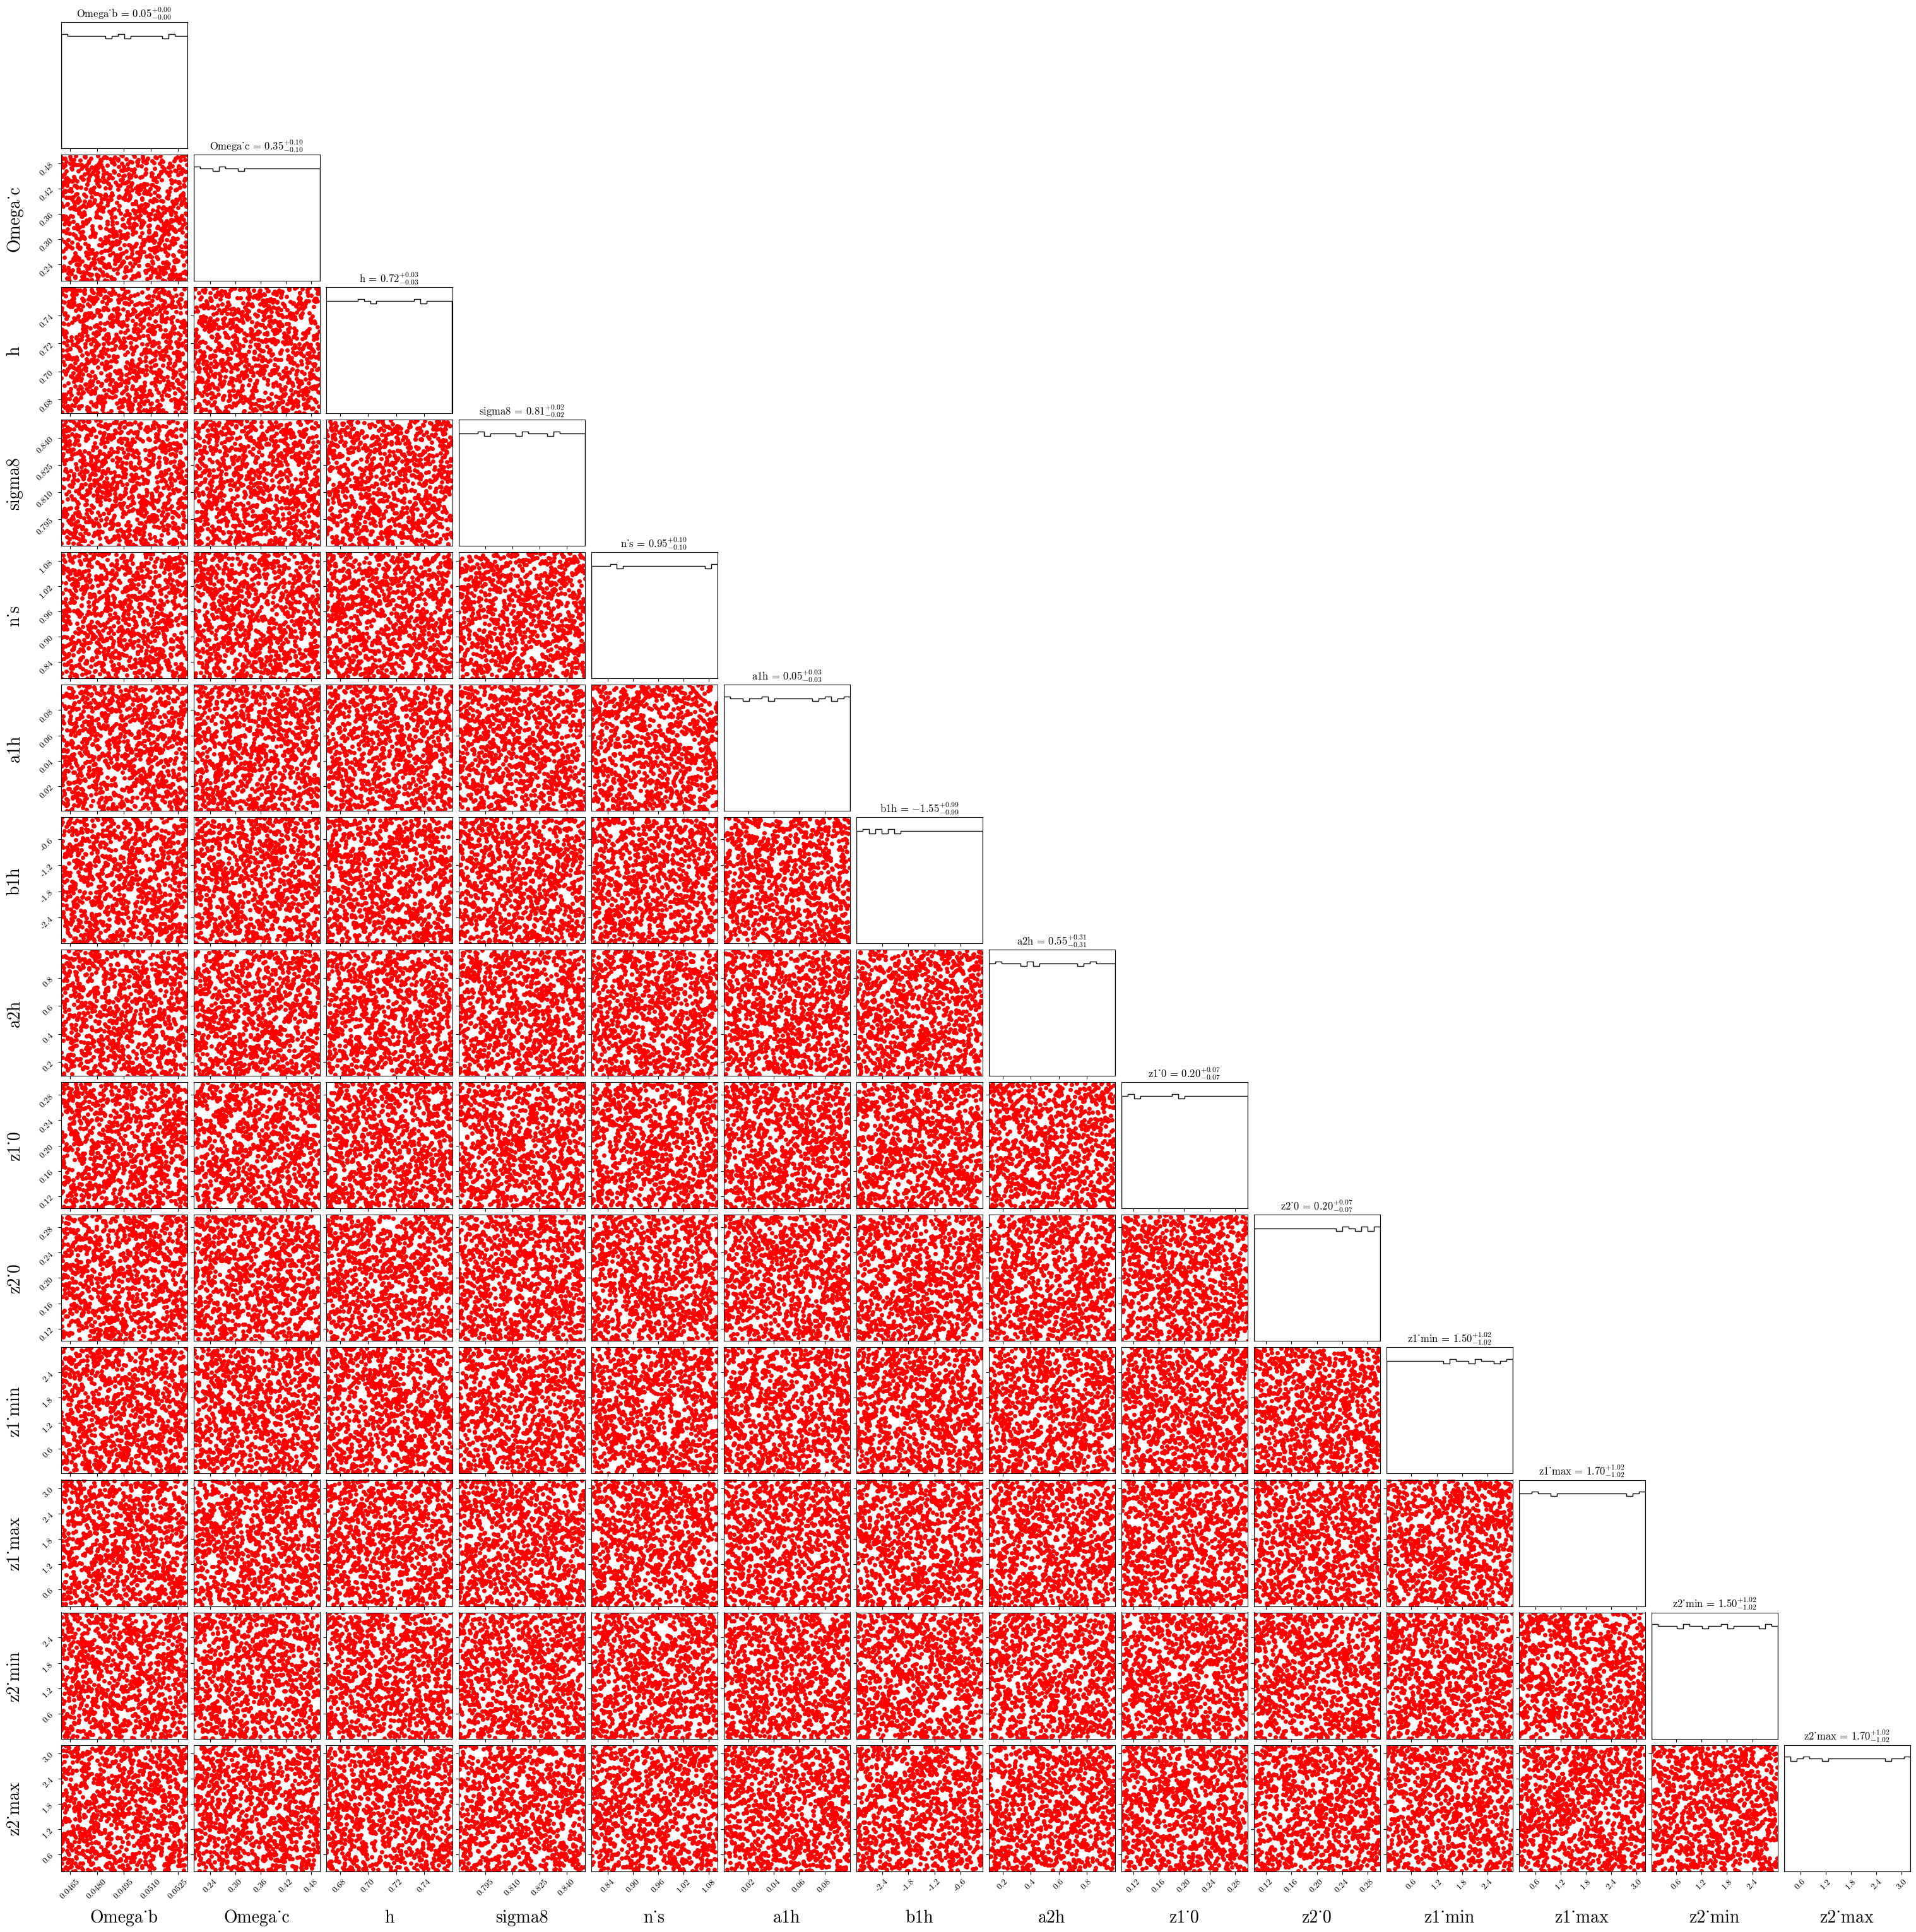

In [177]:
import pandas as pd
import corner
import seaborn as sns
df = pd.DataFrame(lh_samples, columns=[string for string in param_list])

# Use corner plot to visualize
corner.corner(df, labels=[string for string in param_list], show_titles=True,
              plot_contours=False, plot_density=False, plot_datapoints=True,
              data_kwargs={'alpha': 1,'color': 'red','ms' : 5}, label_kwargs={'fontsize': 20})
plt.savefig(dpi=300, fname='hypercube_sampling_plot.png')

In [174]:
c_ell_task_types = ['gg','gk','kk']
    # Start creating a training set

for i in range(n_samples):

    cosmo = ccl.Cosmology(Omega_c=df.iloc[i]['Omega_c'], Omega_b=df.iloc[i]['Omega_b'], 
                          h=df.iloc[i]['h'], sigma8=df.iloc[i]['sigma8'], n_s=df.iloc[i]['n_s'])
    
    z1 = np.linspace(df.iloc[i]['z1_min'], df.iloc[i]['z1_max'], 256)
    z2 = np.linspace(df.iloc[i]['z2_min'], df.iloc[i]['z2_max'], 256)
    theta = np.geomspace(0.1, df.iloc[i]['theta'], 40)

Omega_b     0.051168
Omega_c     0.237018
h           0.732015
sigma8      0.833028
n_s         0.887788
a1h         0.061843
b1h        -1.455755
a2h         0.160213
z1_0        0.249308
z2_0        0.127581
z1_min      0.778530
z1_max      2.193433
z2_min      1.316557
z2_max      0.676949
theta      14.848611
Name: 0, dtype: float64
